# Healthcare Facility Audit Prediction Analysis

### Project Overview
This project develops an advanced machine learning system to predict healthcare facility audit risks. We leverage:
- 246 financial and operational features from California hospital data
- Advanced categorical encoding (target encoding, one-hot encoding)
- Extensive feature engineering (financial ratios, utilization metrics, aggregations)
- Feature selection (correlation, mutual information, recursive feature elimination)
- Advanced models (LightGBM, CatBoost, Neural Networks)
- Ensemble stacking for optimal performance

## Setup

In [1]:
%%capture

pip install -U scikit-learn==1.3.2 imbalanced-learn catboost==1.2.3

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif, RFE, SelectKBest, chi2
from sklearn.metrics import (
    roc_auc_score, log_loss, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, precision_recall_curve,
    average_precision_score
)
from sklearn.calibration import calibration_curve
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from category_encoders import TargetEncoder
import shap
import joblib

In [3]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Load and Explore Data

In [4]:
data = pd.read_csv('data\Healthcare Facility Analysis Data.csv')

print(f"Dataset shape: {data.shape}")
print(f"\nNumber of unique facilities: {data['FAC_NO'].nunique()}")
print(f"Number of features: {data.shape[1]}")
print(f"\nColumns:\n{data.columns.tolist()}")
print(f"\nData types:\n{data.dtypes.value_counts()}")
print(f"\nMissing values:\n{data.isnull().sum().sum()} total")
print(f"\nTarget distribution:\n{data['AUDIT_IND'].value_counts()}")

Dataset shape: (578350, 35)

Number of unique facilities: 472
Number of features: 35

Columns:
['FAC_NO', 'FAC_NAME', 'BEG_DATE', 'END_DATE', 'DAY_PER', 'DATA_IND', 'AUDIT_IND', 'COUNTY', 'HSA', 'HFPA', 'TYPE_CNTRL', 'TYPE_CARE', 'TYPE_HOSP', 'TEACH_RURL', 'PHONE', 'ADDRESS', 'CITY', 'ZIP_CODE', 'CEO', 'CEO_TITLE', 'WEB_SITE', 'OWNER', 'RPT_PREP', 'ORG_NAME', 'ER_DESIG', 'MCAR_PRO#', 'MCAL_PRO#', 'REG_MCAL#', 'BED_LIC', 'BED_AVL', 'BED_STF', 'Variable', 'Amount', 'WEB-SITE', 'ORG-NAME']

Data types:
object     29
int64       4
float64     2
Name: count, dtype: int64

Missing values:
2602790 total

Target distribution:
AUDIT_IND
Incl. Ind. Audit Adj.    345075
Excl. Ind. Audit Adj.    233275
Name: count, dtype: int64


In [5]:
data.head()

,FAC_NO,FAC_NAME,BEG_DATE,END_DATE,DAY_PER,DATA_IND,AUDIT_IND,COUNTY,HSA,HFPA,...,MCAR_PRO#,MCAL_PRO#,REG_MCAL#,BED_LIC,BED_AVL,BED_STF,Variable,Amount,WEB-SITE,ORG-NAME
0,106010735,ALAMEDA HOSPITAL,01JUL2011,30JUN2012,366,Audited,Incl. Ind. Audit Adj.,Alameda,5,417,...,05-0211,HSC00211F,ZZR00211F,161,161,161,DAY_ MCAR_TR,12330.0,NaN,NaN
1,106010735,ALAMEDA HOSPITAL,01JUL2011,30JUN2012,366,Audited,Incl. Ind. Audit Adj.,Alameda,5,417,...,05-0211,HSC00211F,ZZR00211F,161,161,161,DAY_MCAR_MC,885.0,NaN,NaN
2,106010735,ALAMEDA HOSPITAL,01JUL2011,30JUN2012,366,Audited,Incl. Ind. Audit Adj.,Alameda,5,417,...,05-0211,HSC00211F,ZZR00211F,161,161,161,DAY_MCAL_TR,13093.0,NaN,NaN
3,106010735,ALAMEDA HOSPITAL,01JUL2011,30JUN2012,366,Audited,Incl. Ind. Audit Adj.,Alameda,5,417,...,05-0211,HSC00211F,ZZR00211F,161,161,161,DAY_ MCAL_ MC,1786.0,NaN,NaN
4,106010735,ALAMEDA HOSPITAL,01JUL2011,30JUN2012,366,Audited,Incl. Ind. Audit Adj.,Alameda,5,417,...,05-0211,HSC00211F,ZZR00211F,161,161,161,DAY_CNTY,0.0,NaN,NaN


In [6]:
data.select_dtypes('object').head()

,FAC_NAME,BEG_DATE,END_DATE,DATA_IND,AUDIT_IND,COUNTY,TYPE_CNTRL,TYPE_CARE,TYPE_HOSP,TEACH_RURL,...,ORG_NAME,MCAR_PRO#,MCAL_PRO#,REG_MCAL#,BED_LIC,BED_AVL,BED_STF,Variable,WEB-SITE,ORG-NAME
0,ALAMEDA HOSPITAL,01JUL2011,30JUN2012,Audited,Incl. Ind. Audit Adj.,Alameda,District,General,Comparable,NaN,...,PACIFIC HOSPITAL MANAGEMENT,05-0211,HSC00211F,ZZR00211F,161,161,161,DAY_ MCAR_TR,NaN,NaN
1,ALAMEDA HOSPITAL,01JUL2011,30JUN2012,Audited,Incl. Ind. Audit Adj.,Alameda,District,General,Comparable,NaN,...,PACIFIC HOSPITAL MANAGEMENT,05-0211,HSC00211F,ZZR00211F,161,161,161,DAY_MCAR_MC,NaN,NaN
2,ALAMEDA HOSPITAL,01JUL2011,30JUN2012,Audited,Incl. Ind. Audit Adj.,Alameda,District,General,Comparable,NaN,...,PACIFIC HOSPITAL MANAGEMENT,05-0211,HSC00211F,ZZR00211F,161,161,161,DAY_MCAL_TR,NaN,NaN
3,ALAMEDA HOSPITAL,01JUL2011,30JUN2012,Audited,Incl. Ind. Audit Adj.,Alameda,District,General,Comparable,NaN,...,PACIFIC HOSPITAL MANAGEMENT,05-0211,HSC00211F,ZZR00211F,161,161,161,DAY_ MCAL_ MC,NaN,NaN
4,ALAMEDA HOSPITAL,01JUL2011,30JUN2012,Audited,Incl. Ind. Audit Adj.,Alameda,District,General,Comparable,NaN,...,PACIFIC HOSPITAL MANAGEMENT,05-0211,HSC00211F,ZZR00211F,161,161,161,DAY_CNTY,NaN,NaN


In [7]:
cols = ['BED_LIC', 'BED_AVL', 'BED_STF']

for col in cols:
    if col in data.columns:
        data[col] = (
            data[col]
            .astype(str)
            .str.replace(',', '', regex=False)
            .astype(float)
        )

data['AUDIT_IND'] = data['AUDIT_IND'].map({
    "Incl. Ind. Audit Adj.": 1,
    "Excl. Ind. Audit Adj.": 0
})

## Data Preprocessing & Feature Engineering

### Identify Feature Categories

In [8]:
categorical_cols = ['COUNTY', 'CITY', 'TYPE_CNTRL', 'TYPE_CARE', 'TYPE_HOSP']
identifier_cols = ['FAC_NO', 'FAC_NAME']
target_col = 'AUDIT_IND'

variable_col = 'Variable'
amount_col = 'Amount'

numeric_cols = ['BED_LIC', 'BED_AVL', 'BED_STF']

print(f"Categorical columns: {categorical_cols}")
print(f"Identifier columns: {identifier_cols}")
print(f"Numeric columns: {numeric_cols}")
print(f"\nUnique Variables: {data[variable_col].nunique()}")
print(f"\nSample Variables:\n{data[variable_col].unique()[:20]}")

Categorical columns: ['COUNTY', 'CITY', 'TYPE_CNTRL', 'TYPE_CARE', 'TYPE_HOSP']
Identifier columns: ['FAC_NO', 'FAC_NAME']
Numeric columns: ['BED_LIC', 'BED_AVL', 'BED_STF']

Unique Variables: 228

Sample Variables:
['DAY_ MCAR_TR' 'DAY_MCAR_MC' 'DAY_MCAL_TR' 'DAY_ MCAL_ MC' 'DAY_CNTY'
 'DAY_THRD_TR' 'DAY_THRD_MC' 'DAY_OTH_ IND' 'DAY_OTH' 'DAY_TOT'
 'DIS_MCAR_TR' 'DIS_MCAR_MC' 'DIS_MCAL_TR' 'DIS_MCAL_MC' 'DIS_CNTY'
 'DIS_THRD_TR' 'DIS_THRD_MC' 'DIS_OTH_IND' 'DIS_OTH' 'DIS_TOT']


### Pivot Data from Long to Wide Format

The data is currently in long format with Variables in rows. We'll pivot to wide format where each Variable becomes a feature.

In [9]:
print("Pivoting data from long to wide format")

cat_agg = {col: 'first' for col in categorical_cols}

num_agg = {
    'BED_LIC': 'max',
    'BED_AVL': 'max',
    'BED_STF': 'max'
}

target_agg = {target_col: 'max'}

agg_dict = {**cat_agg, **num_agg, **target_agg}

base_data = (
    data
    .groupby('FAC_NO', as_index=False)
    .agg(agg_dict)
)

pivoted_financial = data.pivot_table(
    index='FAC_NO',
    columns='Variable',
    values='Amount',
    aggfunc='sum',
    fill_value=0
)

pivoted_financial.columns = [f'FIN_{col}' for col in pivoted_financial.columns]

wide_data = base_data.merge(
    pivoted_financial,
    on='FAC_NO',
    how='left'
)

print(f"\nWide data shape: {wide_data.shape}")
print(f"Number of facilities: {wide_data['FAC_NO'].nunique()}")
print(f"Total features (before engineering): {wide_data.shape[1]}")

wide_data.head()

Pivoting data from long to wide format

Wide data shape: (472, 238)
Number of facilities: 472
Total features (before engineering): 238


,FAC_NO,COUNTY,CITY,TYPE_CNTRL,TYPE_CARE,TYPE_HOSP,BED_LIC,BED_AVL,BED_STF,AUDIT_IND,...,FIN_VIS_MCAL_MC,FIN_VIS_MCAL_TR,FIN_VIS_MCAR_MC,FIN_VIS_MCAR_TR,FIN_VIS_OTH,FIN_VIS_OTH_IND,FIN_VIS_REF_OP,FIN_VIS_THRD_MC,FIN_VIS_THRD_TR,FIN_VIS_TOT
0,106010735,Alameda,ALAMEDA,District,General,Comparable,281.0,281.0,221.0,1,...,66901.0,18861.0,46375.0,431333.0,120703.0,2934.0,175912.0,69879.0,145600.0,908393.0
1,106010739,Alameda,BERKELEY,Non-Profit,General,Comparable,458.0,491.0,357.0,1,...,128923.0,43696.0,51447.0,237780.0,23073.0,10254.0,202005.0,464352.0,21602.0,981833.0
2,106010776,Alameda,OAKLAND,Non-Profit,Childrens,Comparable,190.0,190.0,153.0,1,...,530622.0,365471.0,0.0,18936.0,12649.0,13580.0,103207.0,326282.0,4384.0,1272672.0
3,106010782,Alameda,OAKLAND,Non-Profit,Specialty,Comparable,50.0,50.0,50.0,1,...,0.0,0.0,0.0,0.0,241.0,0.0,0.0,1126.0,0.0,1367.0
4,106010805,Alameda,CASTRO VALLEY,Non-Profit,General,Comparable,271.0,271.0,157.0,1,...,19341.0,5278.0,5960.0,22659.0,5593.0,11531.0,48735.0,23737.0,3234.0,97344.0


### Create Engineered Features

We'll create meaningful features from financial and operational data:
- Financial ratios (profitability, liquidity, efficiency)
- Utilization metrics (occupancy rates, patient flow)
- Revenue composition (payer mix, revenue sources)
- Expense efficiency (cost per patient, labor productivity)

In [ ]:
def create_engineered_features(df):
    df_eng = df.copy()

    df_eng['Bed_Utilization'] = df_eng['BED_AVL'] / (df_eng['BED_LIC'] + 1)

    # This captures how much of a hospital’s licensed capacity is actually available for patient care.

    if 'FIN_GR_PT_REV' in df_eng.columns and 'FIN_NET_PT_REV' in df_eng.columns:
        df_eng['Deduction_Rate'] = 1 - (df_eng['FIN_NET_PT_REV'] / (df_eng['FIN_GR_PT_REV'] + 1))

    # FIN_GR_PT_REV, Gross Patient Revenue, total charges at full established rates
    # FIN_NET_PT_REV, Net Patient Revenue, revenue after contractual adjustments, bad debt, charity care

    # The proportion of gross revenue that is written off through deductions. A higher value means the hospital discounts or writes off a larger share of billed charges.
    # High or volatile deduction rates can signal aggressive billing, payer mix risk, or potential misclassification of revenue and adjustments

    if 'FIN_NET_INCOME' in df_eng.columns and 'FIN_NET_PT_REV' in df_eng.columns:
        df_eng['Profit_Margin'] = df_eng['FIN_NET_INCOME'] / (df_eng['FIN_NET_PT_REV'] + 1)

    # FIN_NET_INCOME, Net Income, final profit after all revenues and expenses
    # FIN_NET_PT_REV, Net Patient Revenue
    # Overall profitability from patient operations

    if 'FIN_NET_FRM_OP' in df_eng.columns and 'FIN_NET_PT_REV' in df_eng.columns:
        df_eng['Operating_Margin'] = df_eng['FIN_NET_FRM_OP'] / (df_eng['FIN_NET_PT_REV'] + 1)

    # FIN_NET_FRM_OP, Net from Operations, operating income before non operating items
    # FIN_NET_PT_REV, Net Patient Revenue
    # Profitability strictly from core hospital operations

    if 'FIN_TOT_OP_EXP' in df_eng.columns and 'FIN_NET_PT_REV' in df_eng.columns:
        df_eng['Cost_to_Revenue_Ratio'] = df_eng['FIN_TOT_OP_EXP'] / (df_eng['FIN_NET_PT_REV'] + 1)

    # FIN_TOT_OP_EXP, Total Operating Expenses
    # FIN_NET_PT_REV, Net Patient Revenue
    # How much it costs to generate one dollar of patient revenue

    if 'FIN_DAY_TOT' in df_eng.columns and 'FIN_DIS_TOT' in df_eng.columns:
        df_eng['Avg_Length_of_Stay'] = df_eng['FIN_DAY_TOT'] / (df_eng['FIN_DIS_TOT'] + 1)

    # FIN_DAY_TOT, Total Patient Days
    # FIN_DIS_TOT, Total Discharges
    # Average inpatient length of stay across all payers


    if 'FIN_DAY_TOT' in df_eng.columns and 'BED_LIC' in df_eng.columns:
        df_eng['Occupancy_Rate'] = df_eng['FIN_DAY_TOT'] / (df_eng['BED_LIC'] * 365 + 1)
    
    # FIN_DAY_TOT, Total Patient Days
    # BED_LIC, Licensed Beds
    # How intensively licensed bed capacity is used over the year

    if 'FIN_NET_PT_REV' in df_eng.columns and 'FIN_DIS_TOT' in df_eng.columns:
        df_eng['Revenue_per_Discharge'] = df_eng['FIN_NET_PT_REV'] / (df_eng['FIN_DIS_TOT'] + 1)

    # FIN_NET_PT_REV, Net Patient Revenue
    # FIN_DIS_TOT, Total Discharges
    # Average revenue generated per inpatient discharge

    if 'FIN_TOT_OP_EXP' in df_eng.columns and 'FIN_DIS_TOT' in df_eng.columns:
        df_eng['Cost_per_Discharge'] = df_eng['FIN_TOT_OP_EXP'] / (df_eng['FIN_DIS_TOT'] + 1)

    # FIN_TOT_OP_EXP, Total Operating Expenses
    # FIN_DIS_TOT, Total Discharges
    # Average cost incurred per discharge

    if 'FIN_TOT_OP_EXP' in df_eng.columns and 'FIN_DAY_TOT' in df_eng.columns:
        df_eng['Cost_per_Patient_Day'] = df_eng['FIN_TOT_OP_EXP'] / (df_eng['FIN_DAY_TOT'] + 1)

    # FIN_TOT_OP_EXP, Total Operating Expenses
    # FIN_DAY_TOT, Total Patient Days
    # Cost of delivering one inpatient day of care

    medicare_cols = [c for c in df_eng.columns if c.startswith('FIN_') and 'MCAR' in c]
    if medicare_cols:
        df_eng['Medicare_Total'] = df_eng[medicare_cols].sum(axis=1)
    
    # Total financial exposure to Medicare across all reported categories
    # Medicare reimbursement is highly regulated, hospitals with large Medicare exposure face higher audit risk

    medicaid_cols = [c for c in df_eng.columns if c.startswith('FIN_') and 'MCAL' in c]
    if medicaid_cols:
        df_eng['Medicaid_Total'] = df_eng[medicaid_cols].sum(axis=1)

    # Total financial exposure to Medi Cal
    # Medi Cal programs involve complex supplemental payments and adjustments, often audited for compliance

    if 'Medicare_Total' in df_eng.columns and 'FIN_NET_PT_REV' in df_eng.columns:
        df_eng['Medicare_Pct'] = df_eng['Medicare_Total'] / (df_eng['FIN_NET_PT_REV'] + 1)

    # FIN_NET_PT_REV, Net Patient Revenue
    # Share of net patient revenue attributable to Medicare

    if 'Medicaid_Total' in df_eng.columns and 'FIN_NET_PT_REV' in df_eng.columns:
        df_eng['Medicaid_Pct'] = df_eng['Medicaid_Total'] / (df_eng['FIN_NET_PT_REV'] + 1)
    
    # FIN_NET_PT_REV, Net Patient Revenue
    # Share of net patient revenue attributable to Medi Cal

    if 'FIN_CUR_ASST' in df_eng.columns and 'FIN_CUR_LIAB' in df_eng.columns:
        df_eng['Current_Ratio'] = df_eng['FIN_CUR_ASST'] / (df_eng['FIN_CUR_LIAB'] + 1)

    # FIN_CUR_ASST, Current Assets
    # FIN_CUR_LIAB, Current Liabilities
    # Short term liquidity and ability to meet obligations

    if 'FIN_CASH' in df_eng.columns and 'FIN_CUR_LIAB' in df_eng.columns:
        df_eng['Cash_Ratio'] = df_eng['FIN_CASH'] / (df_eng['FIN_CUR_LIAB'] + 1)

    # FIN_CASH, Cash and cash equivalents
    # FIN_CUR_LIAB, Current Liabilities
    # Immediate liquidity without relying on receivables

    if 'FIN_TOT_ASST' in df_eng.columns and 'FIN_NET_PT_REV' in df_eng.columns:
        df_eng['Asset_Turnover'] = df_eng['FIN_NET_PT_REV'] / (df_eng['FIN_TOT_ASST'] + 1)

    # FIN_NET_PT_REV, Net Patient Revenue
    # FIN_TOT_ASST, Total Assets
    # Efficiency in generating revenue from assets

    if 'FIN_NET_LTDEBT' in df_eng.columns and 'FIN_EQUITY' in df_eng.columns:
        df_eng['Debt_to_Equity'] = df_eng['FIN_NET_LTDEBT'] / (df_eng['FIN_EQUITY'] + 1)

    # FIN_NET_LTDEBT, Net Long Term Debt
    # FIN_EQUITY, Equity
    # Financial leverage

    if 'FIN_NET_LTDEBT' in df_eng.columns and 'FIN_TOT_ASST' in df_eng.columns:
        df_eng['Debt_Ratio'] = df_eng['FIN_NET_LTDEBT'] / (df_eng['FIN_TOT_ASST'] + 1)

    # Portion of assets financed by long term debt

    if 'FIN_HOSP_FTE' in df_eng.columns and 'BED_LIC' in df_eng.columns:
        df_eng['FTE_per_Bed'] = df_eng['FIN_HOSP_FTE'] / (df_eng['BED_LIC'] + 1)
    
    # Staffing intensity relative to hospital size

    if 'FIN_EXP_SAL' in df_eng.columns and 'FIN_TOT_OP_EXP' in df_eng.columns:
        df_eng['Labor_Cost_Pct'] = df_eng['FIN_EXP_SAL'] / (df_eng['FIN_TOT_OP_EXP'] + 1)

    # Share of operating costs devoted to labor

    if 'FIN_VIS_ER' in df_eng.columns and 'FIN_VIS_TOT' in df_eng.columns:
        df_eng['ER_Visit_Pct'] = df_eng['FIN_VIS_ER'] / (df_eng['FIN_VIS_TOT'] + 1)

    # Dependence on emergency services relative to total outpatient volume

    print(f"Created {len(df_eng.columns) - len(df.columns)} engineered features")
    return df_eng

wide_data_eng = create_engineered_features(wide_data)
print(f"\nTotal features after engineering: {wide_data_eng.shape[1]}")

Created 22 engineered features

Total features after engineering: 260


### Handle Categorical Variables

In [11]:
print("Encoding categorical variables")

data_encoded = wide_data_eng.copy()

low_cardinality_cats = []
high_cardinality_cats = []

for col in categorical_cols:
    if col in data_encoded.columns:
        n_unique = data_encoded[col].nunique()
        if n_unique <= 10:
            low_cardinality_cats.append(col)
        else:
            high_cardinality_cats.append(col)

print(f"Low cardinality (<= 10 unique): {low_cardinality_cats}")
print(f"High cardinality (> 10 unique): {high_cardinality_cats}")

for col in low_cardinality_cats:
    dummies = pd.get_dummies(data_encoded[col], prefix=col, drop_first=True)
    data_encoded = pd.concat([data_encoded, dummies], axis=1)
    data_encoded.drop(columns=[col], inplace=True)

print(f"\nOne-hot encoded {len(low_cardinality_cats)} low cardinality features")
print(f"Shape after one-hot encoding: {data_encoded.shape}")

wide_data_eng.head()

Encoding categorical variables
Low cardinality (<= 10 unique): ['TYPE_CNTRL', 'TYPE_CARE', 'TYPE_HOSP']
High cardinality (> 10 unique): ['COUNTY', 'CITY']

One-hot encoded 3 low cardinality features
Shape after one-hot encoding: (472, 270)


,FAC_NO,COUNTY,CITY,TYPE_CNTRL,TYPE_CARE,TYPE_HOSP,BED_LIC,BED_AVL,BED_STF,AUDIT_IND,...,Medicare_Pct,Medicaid_Pct,Current_Ratio,Cash_Ratio,Asset_Turnover,Debt_to_Equity,Debt_Ratio,FTE_per_Bed,Labor_Cost_Pct,ER_Visit_Pct
0,106010735,Alameda,ALAMEDA,District,General,Comparable,281.0,281.0,221.0,1,...,3.977211,2.644288,3.507976e-01,5.142491e-02,0.324596,-0.005736,0.003381,12.315603,0.422826,0.113009
1,106010739,Alameda,BERKELEY,Non-Profit,General,Comparable,458.0,491.0,357.0,1,...,2.081331,1.582881,2.661742e+00,7.259492e-01,1.514678,0.003777,0.002636,23.921569,0.290163,0.274245
2,106010776,Alameda,OAKLAND,Non-Profit,Childrens,Comparable,190.0,190.0,153.0,1,...,0.031152,3.591368,3.990701e+00,6.554781e-01,0.836016,0.576136,0.305033,60.685864,0.380402,0.201891
3,106010782,Alameda,OAKLAND,Non-Profit,Specialty,Comparable,50.0,50.0,50.0,1,...,0.000000,0.000000,3.115602e+00,1.163489e+00,1.948473,0.008360,0.004076,6.411765,0.413172,0.000000
4,106010805,Alameda,CASTRO VALLEY,Non-Profit,General,Comparable,271.0,271.0,157.0,1,...,3.456184,1.550305,1.437261e+08,1.359267e+07,0.542846,0.000066,0.000025,4.316176,0.353569,0.540079


### Handle Missing Values

In [12]:
print(f"Missing values before imputation: {data_encoded.isnull().sum().sum()}")

numeric_features = data_encoded.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col != target_col]

for col in numeric_features:
    data_encoded[col] = data_encoded[col].fillna(data_encoded[col].median())

for col in high_cardinality_cats:
    if col in data_encoded.columns:
        data_encoded[col] = data_encoded[col].fillna('MISSING')

print(f"Missing values after imputation: {data_encoded.isnull().sum().sum()}")

Missing values before imputation: 0
Missing values after imputation: 0


## Train-Test Split

In [13]:
unique_facilities = data_encoded['FAC_NO'].unique()
train_facs, test_facs = train_test_split(
    unique_facilities,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=data_encoded.groupby('FAC_NO')[target_col].first()
)

train_data = data_encoded[data_encoded['FAC_NO'].isin(train_facs)].copy()
test_data = data_encoded[data_encoded['FAC_NO'].isin(test_facs)].copy()

print(f"Train facilities: {len(train_facs)}")
print(f"Test facilities: {len(test_facs)}")
print(f"\nTrain class distribution:\n{train_data[target_col].value_counts()}")
print(f"\nTest class distribution:\n{test_data[target_col].value_counts()}")

Train facilities: 377
Test facilities: 95

Train class distribution:
AUDIT_IND
1    256
0    121
Name: count, dtype: int64

Test class distribution:
AUDIT_IND
1    64
0    31
Name: count, dtype: int64


## Target Encoding for High Cardinality Features

In [14]:
if high_cardinality_cats:
    print(f"Applying target encoding to: {high_cardinality_cats}")
    
    target_encoder = TargetEncoder(cols=high_cardinality_cats, smoothing=1.0)
    
    train_data[high_cardinality_cats] = target_encoder.fit_transform(
        train_data[high_cardinality_cats], 
        train_data[target_col]
    )
    
    test_data[high_cardinality_cats] = target_encoder.transform(
        test_data[high_cardinality_cats]
    )
else:
    print("No high cardinality features to encode")

Applying target encoding to: ['COUNTY', 'CITY']


## Feature Selection

### Remove Low Variance Features

In [15]:
feature_cols = [col for col in train_data.columns 
                if col not in identifier_cols + [target_col]]

X_train = train_data[feature_cols].copy()
y_train = train_data[target_col].copy()
X_test = test_data[feature_cols].copy()
y_test = test_data[target_col].copy()

print(f"Initial feature count: {len(feature_cols)}")

low_variance_threshold = 0.01
variances = X_train.var()
low_var_features = variances[variances < low_variance_threshold].index.tolist()

X_train = X_train.drop(columns=low_var_features)
X_test = X_test.drop(columns=low_var_features)

print(f"Removed {len(low_var_features)} low variance features")
print(f"Remaining features: {X_train.shape[1]}")

Initial feature count: 268
Removed 7 low variance features
Remaining features: 261


### Remove Highly Correlated Features

In [16]:
print("Calculating correlation matrix")
corr_matrix = X_train.corr().abs()

upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)   # Get the strictly upper triangle (k=1)
)

corr_threshold = 0.95
high_corr_features = [column for column in upper_triangle.columns 
                      if any(upper_triangle[column] > corr_threshold)]

X_train = X_train.drop(columns=high_corr_features)
X_test = X_test.drop(columns=high_corr_features)

print(f"Removed {len(high_corr_features)} highly correlated features (>{corr_threshold})")
print(f"Remaining features: {X_train.shape[1]}")

Calculating correlation matrix
Removed 72 highly correlated features (>0.95)
Remaining features: 189


### Mutual Information Feature Selection

In [17]:
print("Calculating mutual information scores")
mi_scores = mutual_info_classif(X_train, y_train, random_state=RANDOM_SEED, n_neighbors=5)
mi_scores = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)

print(f"\nTop 20 features by Mutual Information:")
print(mi_scores.head(20))

top_k_features = 100
top_mi_features = mi_scores.head(top_k_features).index.tolist()

X_train_selected = X_train[top_mi_features].copy()
X_test_selected = X_test[top_mi_features].copy()

print(f"\nSelected top {top_k_features} features by mutual information")

Calculating mutual information scores

Top 20 features by Mutual Information:
FIN_PRD_HR_CLR         0.150922
FIN_EQUIPMENT          0.148067
FIN_EXP_OTHPRO         0.145316
FIN_GR_PT_REV          0.145150
Asset_Turnover         0.144640
FIN_GR_OP_OTH          0.140221
FIN_EXP_BEN            0.136282
FIN_INC_INVEST         0.135578
FIN_CHAR_OTH           0.134532
FIN_NETRV_MCAL_TR      0.130894
FIN_DED_OTH            0.128509
Current_Ratio          0.127702
Labor_Cost_Pct         0.127261
FIN_GR_OP_THRD_TR      0.125002
FIN_GR_IP_OTH          0.123908
FIN_EXP_INTRST         0.121927
FIN_GR_ OP_ OTH_IND    0.121258
FIN_GR_REV_AMB         0.119876
FIN_EXP_PURCH          0.117725
FIN_EXP_DEPRE          0.115509
dtype: float64

Selected top 100 features by mutual information


## Scale Features

In [18]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_selected),
    columns=X_train_selected.columns,
    index=X_train_selected.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_selected),
    columns=X_test_selected.columns,
    index=X_test_selected.index
)

print("Features scaled using StandardScaler")
print(f"Final training shape: {X_train_scaled.shape}")
print(f"Final testing shape: {X_test_scaled.shape}")

Features scaled using StandardScaler
Final training shape: (377, 100)
Final testing shape: (95, 100)


## Handle Class Imbalance with SMOTE

In [19]:
smote = SMOTE(random_state=RANDOM_SEED, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Original: {X_train_scaled.shape}")
print(f"Resampled: {X_train_resampled.shape}")
print(f"\nClass distribution after SMOTE:\n{pd.Series(y_train_resampled).value_counts()}")

Original: (377, 100)
Resampled: (512, 100)

Class distribution after SMOTE:
AUDIT_IND
1    256
0    256
Name: count, dtype: int64


## Model Training

### LightGBM

In [20]:
print("Training LightGBM:")
lgbm_model = LGBMClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=RANDOM_SEED,
    class_weight='balanced',
    n_jobs=-1,
    verbose=-1
)

lgbm_model.fit(X_train_resampled, y_train_resampled)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
lgbm_cv = cross_val_score(lgbm_model, X_train_resampled, y_train_resampled,
                          cv=skf, scoring='roc_auc', n_jobs=-1)

print(f"LightGBM CV ROC-AUC: {lgbm_cv.mean():.4f} (+/- {lgbm_cv.std():.4f})")

Training LightGBM:
LightGBM CV ROC-AUC: 0.9442 (+/- 0.0161)


### CatBoost

In [21]:
print("Training CatBoost:")
catboost_model = CatBoostClassifier(
    iterations=200,
    depth=8,
    learning_rate=0.05,
    l2_leaf_reg=3.0,
    random_state=RANDOM_SEED,
    auto_class_weights='Balanced',
    verbose=0
)

catboost_model.fit(X_train_resampled, y_train_resampled)

catboost_cv = cross_val_score(catboost_model, X_train_resampled, y_train_resampled,
                              cv=skf, scoring='roc_auc', n_jobs=-1)

print(f"CatBoost CV ROC-AUC: {catboost_cv.mean():.4f} (+/- {catboost_cv.std():.4f})")

Training CatBoost:
CatBoost CV ROC-AUC: 0.9456 (+/- 0.0193)


### XGBoost

In [22]:
print("Training XGBoost:")
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=RANDOM_SEED,
    scale_pos_weight=1,
    eval_metric='logloss'
)

xgb_model.fit(X_train_resampled, y_train_resampled)

xgb_cv = cross_val_score(xgb_model, X_train_resampled, y_train_resampled,
                         cv=skf, scoring='roc_auc', n_jobs=-1)

print(f"XGBoost CV ROC-AUC: {xgb_cv.mean():.4f} (+/- {xgb_cv.std():.4f})")

Training XGBoost:
XGBoost CV ROC-AUC: 0.9407 (+/- 0.0175)


### Random Forest

In [23]:
print("Training Random Forest:")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=RANDOM_SEED,
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_train_resampled, y_train_resampled)

rf_cv = cross_val_score(rf_model, X_train_resampled, y_train_resampled,
                        cv=skf, scoring='roc_auc', n_jobs=-1)

print(f"Random Forest CV ROC-AUC: {rf_cv.mean():.4f} (+/- {rf_cv.std():.4f})")

Training Random Forest:
Random Forest CV ROC-AUC: 0.9192 (+/- 0.0174)


### Gradient Boosting

In [24]:
print("Training Gradient Boosting:")
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=RANDOM_SEED
)

gb_model.fit(X_train_resampled, y_train_resampled)

gb_cv = cross_val_score(gb_model, X_train_resampled, y_train_resampled,
                        cv=skf, scoring='roc_auc', n_jobs=-1)

print(f"Gradient Boosting CV ROC-AUC: {gb_cv.mean():.4f} (+/- {gb_cv.std():.4f})")

Training Gradient Boosting:
Gradient Boosting CV ROC-AUC: 0.9444 (+/- 0.0139)


### Stacking Ensemble

In [25]:
print("Training Stacking Classifier:")
stacking_model = StackingClassifier(
    estimators=[
        ('lgbm', lgbm_model),
        ('catboost', catboost_model),
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('gb', gb_model)
    ],
    final_estimator=LogisticRegression(
        C=1.0,
        max_iter=1000,
        random_state=RANDOM_SEED,
        class_weight='balanced'
    ),
    cv=5,
    n_jobs=1
)

stacking_model.fit(X_train_resampled, y_train_resampled)

stacking_cv = cross_val_score(stacking_model, X_train_resampled, y_train_resampled,
                              cv=skf, scoring='roc_auc', n_jobs=1)

print(f"Stacking CV ROC-AUC: {stacking_cv.mean():.4f} (+/- {stacking_cv.std():.4f})")

Training Stacking Classifier:
Stacking CV ROC-AUC: 0.9448 (+/- 0.0198)


## Model Evaluation

In [ ]:
models = {
    'LightGBM': lgbm_model,
    'CatBoost': catboost_model,
    'XGBoost': xgb_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'Stacking Ensemble': stacking_model
}

results = []
predictions = {}

for name, model in models.items():
    y_train_pred_proba = model.predict_proba(X_train_scaled)[:, 1]
    y_test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    y_train_pred = (y_train_pred_proba >= 0.5).astype(int)
    y_test_pred = (y_test_pred_proba >= 0.5).astype(int)
    
    predictions[name] = {
        'y_test': y_test,
        'y_test_pred': y_test_pred,
        'y_test_pred_proba': y_test_pred_proba
    }
    
    results.append({
        'Model': name,
        'Train ROC-AUC': roc_auc_score(y_train, y_train_pred_proba),
        'Test ROC-AUC': roc_auc_score(y_test, y_test_pred_proba),
        'Train Log Loss': log_loss(y_train, y_train_pred_proba),
        'Test Log Loss': log_loss(y_test, y_test_pred_proba),
        'Test Precision': precision_score(y_test, y_test_pred, zero_division=0),
        'Test Recall': recall_score(y_test, y_test_pred, zero_division=0),
        'Test F1': f1_score(y_test, y_test_pred, zero_division=0),
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'Overfitting Gap': roc_auc_score(y_train, y_train_pred_proba) - roc_auc_score(y_test, y_test_pred_proba)
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test ROC-AUC', ascending=False)
results_df

,Model,Train ROC-AUC,Test ROC-AUC,Train Log Loss,Test Log Loss,Test Precision,Test Recall,Test F1,Test Accuracy,Overfitting Gap
4,Gradient Boosting,1.000000,0.885585,0.013582,0.447481,0.887097,0.859375,0.873016,0.831579,0.114415
0,LightGBM,1.000000,0.882056,0.032905,0.436579,0.861538,0.875000,0.868217,0.821053,0.117944
5,Stacking Ensemble,1.000000,0.881048,0.052353,0.423219,0.863636,0.890625,0.876923,0.831579,0.118952
2,XGBoost,1.000000,0.871472,0.035307,0.432027,0.865672,0.906250,0.885496,0.842105,0.128528
1,CatBoost,1.000000,0.866935,0.037937,0.417080,0.885246,0.843750,0.864000,0.821053,0.133065
3,Random Forest,0.993382,0.865423,0.232269,0.438925,0.859375,0.859375,0.859375,0.810526,0.127959


### ROC Curves

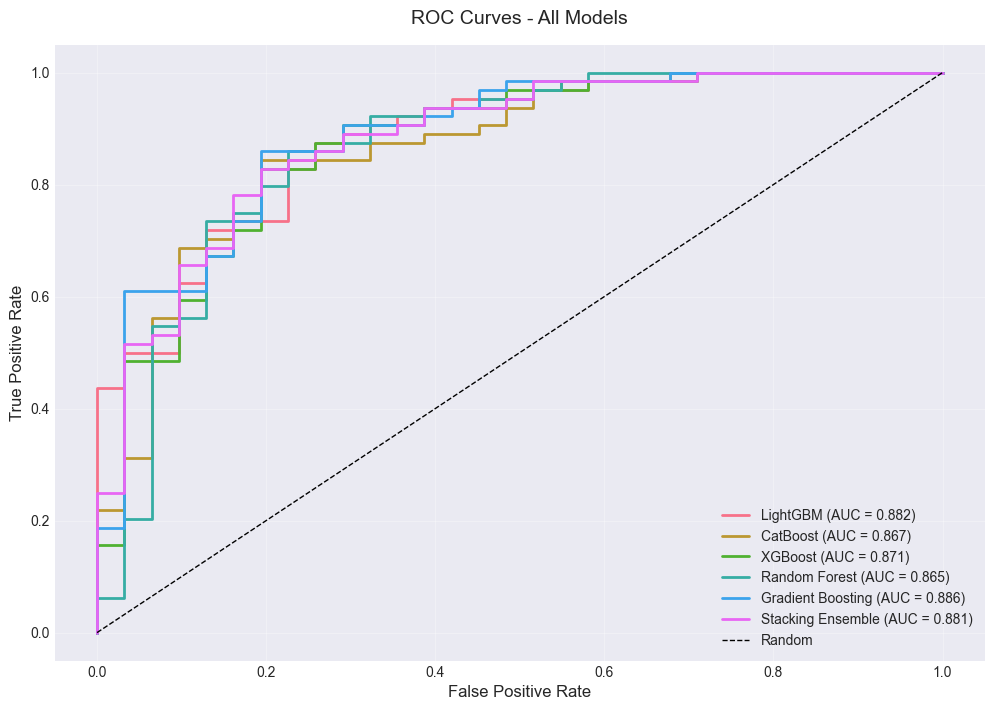

In [27]:
plt.figure(figsize=(12, 8))

for model_name, preds in predictions.items():
    fpr, tpr, _ = roc_curve(preds['y_test'], preds['y_test_pred_proba'])
    auc = roc_auc_score(preds['y_test'], preds['y_test_pred_proba'])
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models', fontsize=14, pad=15)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

### Confusion Matrices

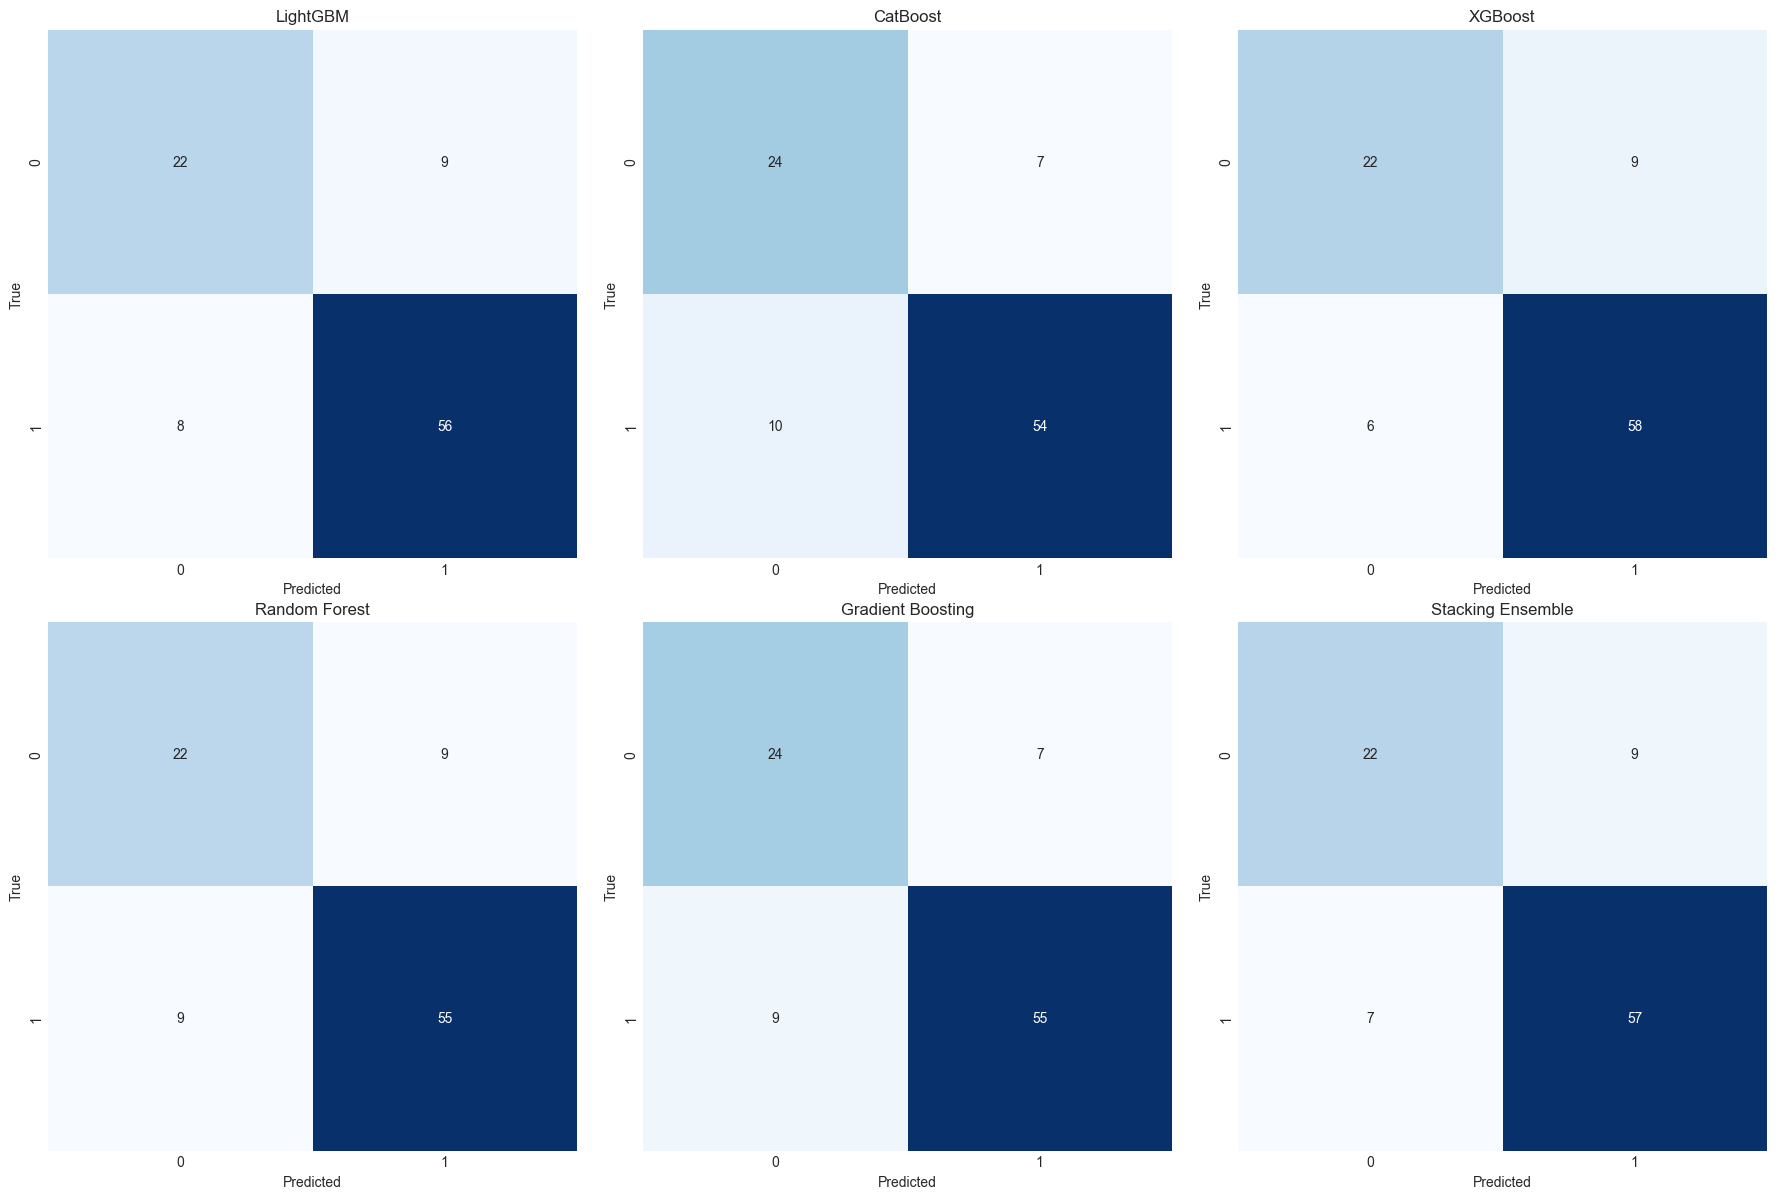

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (model_name, preds) in enumerate(predictions.items()):
    cm = confusion_matrix(preds['y_test'], preds['y_test_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], cbar=False, square=True)
    axes[idx].set_title(f'{model_name}', fontsize=12)
    axes[idx].set_ylabel('True')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

### Feature Importance (Best Model)

Best model: Gradient Boosting


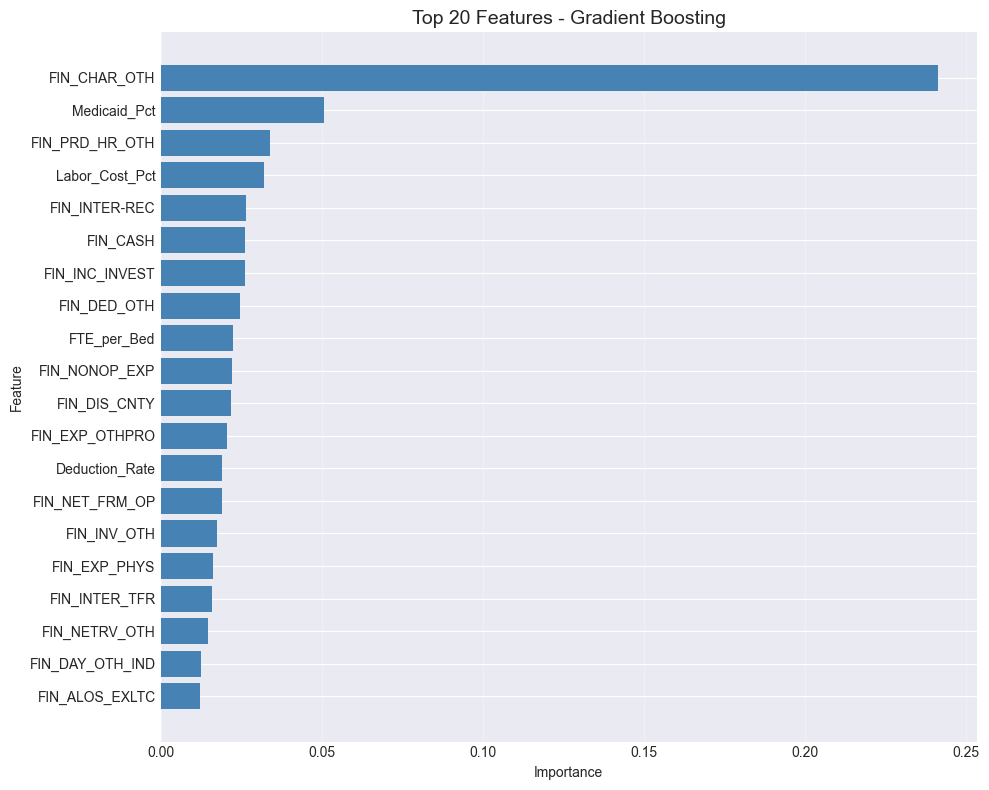

In [29]:
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"Best model: {best_model_name}")

if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': X_train_selected.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).head(20)
    
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['feature'], importance_df['importance'], color='steelblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top 20 Features - {best_model_name}', fontsize=14)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

## Model Persistence

In [31]:
joblib.dump(best_model, f'best_model_{best_model_name.replace(" ", "_")}.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(feature_cols, 'feature_columns.pkl')

print(f"Best model saved: {best_model_name}")
print(f"Test ROC-AUC: {results_df.iloc[0]['Test ROC-AUC']:.4f}")
print(f"Test Log Loss: {results_df.iloc[0]['Test Log Loss']:.4f}")

Best model saved: Gradient Boosting
Test ROC-AUC: 0.8856
Test Log Loss: 0.4475
